In [1]:
import time

import tensorflow as tf
import numpy as np

import skimage
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
import custom_vgg19

In [2]:
BATCH_SIZE = 10
input_shape = [BATCH_SIZE, 256, 256, 3]
STYLE_LAYERS = ('conv1_1', 'conv2_1', 'conv3_1', 'conv4_1')
CONTENT_LAYER = 'conv4_2'
CONTENT_WEIGHT = 7.5
STYLE_WEIGHT = 100
NEW_H, NEW_W =256, 256

In [3]:
def load_image_as_batch_with_optional_resize(path, newH=None, newW=None):
    img = skimage.io.imread(path)
    img = img / 255.0
    
    oldH, oldW = img.shape[0], img.shape[1] # assume h,w is shape[0] and [1] respectively
    if newH != None or newW != None:
        if newW is None:
            newW = int(oldW * float(newH) / oldH)
        elif newH is None:
            newH = int(oldH * float(newW) / oldW)
        img = skimage.transform.resize(img, (newH, newW))
    
    # delete the Alpha channel if the image is RGBA to make sure # channel is correct
    if img.shape[2]==4:
        img = img[:,:,0:3]
        
    # add another dimension to make it a batch , bacause our vgg19 def takes a batch
    img = img.reshape((1,)+img.shape)
    return img

In [4]:
def build(img, debugSess=None):
    assert input_shape == [d.value for d in img.get_shape()]   # now we fix the image size and assume 
      # img has an already-defined shape. Otherwise Tensorflow will fail to infer the output shape of the layer
        # which is very inconvinent for debugging
    
    # img = tf.pad(img, [[40,40],[40,40]]) # TODO maybe add it later after I finished it. 
            # But I don't know why fast-style-transfer repo doesn't follow the paper's supp material PDF to
            #    (1) have this padding step
            #    (2) not use padding in the residual blocks' conv layers
            # Maybe I can try to implement it later to see if it can produce better images
    conv1 = conv_layer(img, n_in_channel=3, n_out_channel=32, filter_size=9, stride=1, hasRelu=True)
    conv2 = conv_layer(conv1, n_in_channel=32, n_out_channel=64, filter_size=3, stride=2, hasRelu=True)
    conv3 = conv_layer(conv2, n_in_channel=64, n_out_channel=128, filter_size=3, stride=2, hasRelu=True)
    res1 = residual_block(conv3, n_in_channel=128, n_out_channel=128)
    res2 = residual_block(res1, n_in_channel=128, n_out_channel=128)
    res3 = residual_block(res2, n_in_channel=128, n_out_channel=128)
    res4 = residual_block(res3, n_in_channel=128, n_out_channel=128)
    res5 = residual_block(res4, n_in_channel=128, n_out_channel=128)
    deconv1 = de_conv_layer(res5, n_in_channel=128, n_out_channel=64, filter_size=3, stride=2)
    deconv2 = de_conv_layer(deconv1, n_in_channel=64, n_out_channel=32, filter_size=3, stride=2)
    convColor = conv_layer(deconv2, n_in_channel=32, n_out_channel=3, filter_size=9, stride=1)
    tanh = tf.nn.tanh(convColor) * 150 + 255./2  # TODO: why tanh * 150 ? why + 255/2 ? 
    scaled_01 = tanh / 255.0
    
    return scaled_01
    
def conv_layer(input, n_in_channel, n_out_channel, filter_size, stride, hasRelu=True):
    # TODO conv layer without adding bias ( bias is not used in paper either). but I could try it later if time permitted. tf.nn.bias_add
    filt = tf.Variable(tf.truncated_normal([filter_size, filter_size, n_in_channel, n_out_channel], stddev=.1))
    output = tf.nn.conv2d(input, filt, [1,stride,stride,1], padding='SAME')
    output = _instance_norm(output) # TODO read what is instance normalization 
    if hasRelu:
        output = tf.nn.relu(output)
    print("conv layer, output size: %s" % ([i.value for i in output.get_shape()]))
    return output

def de_conv_layer(input, n_in_channel, n_out_channel, filter_size, stride):
    filt = tf.Variable(tf.truncated_normal([filter_size, filter_size, n_out_channel, n_in_channel], stddev=.1))
    in_shape = [s.value for s in input.get_shape()]
    out_shape = [in_shape[0], in_shape[1]*stride, in_shape[2]*stride, n_out_channel]
    output = tf.nn.conv2d_transpose(input, filt, output_shape=out_shape, strides=[1,stride, stride, 1])
    print("deconv layer, output size: %s" % ([i.value for i in output.get_shape()]))
    return output

def residual_block(input, n_in_channel, n_out_channel, name="n/a"):
    print("START residual_block ")
    output = conv_layer(input, n_in_channel, n_out_channel, filter_size=3, stride=1, hasRelu=True)
    output = conv_layer(output,n_out_channel, n_out_channel, filter_size=3, stride=1, hasRelu=False)
    output = input + output
    print("END residual_block")
    return output
    

# TODO Read what is instance normalization. The following code is copied, I don't know how it works
def _instance_norm(net):
    batch, rows, cols, channels = [i.value for i in net.get_shape()]
    var_shape = [channels]
    mu, sigma_sq = tf.nn.moments(net, [1,2], keep_dims=True)
    shift = tf.Variable(tf.zeros(var_shape))
    scale = tf.Variable(tf.ones(var_shape))
    epsilon = 1e-3
    normalized = (net-mu)/(sigma_sq + epsilon)**(.5)
    return scale * normalized + shift


In [5]:
styleimg = load_image_as_batch_with_optional_resize('./picasso_selfport1907.jpg')
print(styleimg.shape)
contentimg = load_image_as_batch_with_optional_resize('./brad_pitt.jpg', newH=NEW_H, newW=NEW_W)
print(contentimg.shape)

# show image
# skimage.io.imshow(contentimg[0])
# plt.show()

(1, 600, 468, 3)
(1, 256, 256, 3)


In [6]:
def gram_matrix(feat_map_batch):
    # We don't need to handle unknown shape here. Otherwise: we can use tf.cast(tf.shape(feat_map_batch), tf.int32)
    bsize, h, w, ch  = feat_map_batch.get_shape().as_list()
    F = tf.reshape(feat_map_batch, [bsize, -1, ch])

    # TODO if m<n, compute feat_map*feat_map, else compute feat_map'*feat_map 
    gram = tf.batch_matmul(F, F, adj_x=True)/ (h * w * ch) # not sure why  we have "/ch". if not, the style_loss is too big
    return gram

def compute_style_loss(gram_target, feat_map_batch):
    bsize, h, w, ch  = feat_map_batch.get_shape().as_list()
    # TODO : test broadcasting and shape is correct for all tensors
    G1, G2_batch = gram_target, gram_matrix(feat_map_batch)
    style_loss =  tf.nn.l2_loss(G1-G2_batch) / bsize / (ch**2) # ch^2 is #element in G1
    return style_loss

def compute_content_loss(feat_map_target, feat_map_batch):
    bsize, h, w, ch  = feat_map_batch.get_shape().as_list()
    content_loss = tf.nn.l2_loss(feat_map_target-feat_map_batch)/(bsize*h*w*ch)
    return content_loss

In [7]:
# Now we can go ahead and extract content features and style features
sess=tf.Session()
styleimg_ph = tf.placeholder(tf.float32, shape=styleimg.shape)
vgg19factory = custom_vgg19.Vgg19Factory()
vgg19_pretrain = vgg19factory.build(styleimg_ph)

# sanity check: make sure the layer names are correct
try:
    style_layers_pretrain = [getattr(vgg19_pretrain, name) for name in STYLE_LAYERS]
    content_layer_pretrain = getattr(vgg19_pretrain, CONTENT_LAYER)
except Exception as ex:
    print ex,  "incorrect layer name. Note: all layer named 'conv' is relu. e.g. 'conv1_1' is actually 'relu1_1'"
    sys.exit(1)

styleimg_grams = [gram_matrix(l) for l in style_layers_pretrain]
styleimg_grams_np = sess.run(styleimg_grams, feed_dict={styleimg_ph:styleimg})
# contentimg_feat_map_np = sess.run(content_layer_pretrain, feed_dict={styleimg_ph:contentimg}) # just for debug propose. It's not slow neural-style, so there is no target content img during training
styleimg_grams = [tf.constant(g, dtype=tf.float32) for g in styleimg_grams_np]

/work/04006/zhuode93/maverick/dlproj2/trainable-neural-style/tensorflow_vgg/vgg19.npy
npy file loaded


In [8]:
# construct img transfrom network
img_train = tf.placeholder(tf.float32, input_shape)
img_pred = build(img_train)

conv layer, output size: [10, 256, 256, 32]
conv layer, output size: [10, 128, 128, 64]
conv layer, output size: [10, 64, 64, 128]
START residual_block 
conv layer, output size: [10, 64, 64, 128]
conv layer, output size: [10, 64, 64, 128]
END residual_block
START residual_block 
conv layer, output size: [10, 64, 64, 128]
conv layer, output size: [10, 64, 64, 128]
END residual_block
START residual_block 
conv layer, output size: [10, 64, 64, 128]
conv layer, output size: [10, 64, 64, 128]
END residual_block
START residual_block 
conv layer, output size: [10, 64, 64, 128]
conv layer, output size: [10, 64, 64, 128]
END residual_block
START residual_block 
conv layer, output size: [10, 64, 64, 128]
conv layer, output size: [10, 64, 64, 128]
END residual_block
deconv layer, output size: [10, 128, 128, 64]
deconv layer, output size: [10, 256, 256, 32]
conv layer, output size: [10, 256, 256, 3]


In [9]:
# construct vgg19 to extract pred img's content & style
vgg19_pred = vgg19factory.build(img_pred)  # make sure pred img have VGG19's desired scale and range([0,1])
style_layers_pred = [getattr(vgg19_pred, name) for name in STYLE_LAYERS]
content_layer_pred = getattr(vgg19_pred, CONTENT_LAYER)

# construct vgg19 to extract train img's content as ground truth
vgg19_extractContent = vgg19factory.build(img_train)    # TODO ugly solution! 
   # So, in total I have to build 3 same vgg19 just because I have different input Tensor 
    # (two are placeholders of different shapes; the other one is the predicted image). Any way to avoid this?
content_layer_target = getattr(vgg19_extractContent, CONTENT_LAYER)


In [10]:
style_losses = [compute_style_loss(styleimg_grams[i], style_layers_pred[i]) for i in xrange(len(styleimg_grams))]
content_loss = compute_content_loss(content_layer_target, content_layer_pred)
loss = STYLE_WEIGHT * reduce(tf.add, style_losses) + CONTENT_WEIGHT * content_loss
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_op = optimizer.minimize(loss)

** integration test: read some pictures and overfit the network to it **

In [11]:
import os
test_batch_f = filter(lambda s:s.startswith('COCO'), os.listdir('data'))[:BATCH_SIZE]
assert len(test_batch_f) == BATCH_SIZE, ('not enough files', len(test_batch_f))
test_batch_np = np.zeros(input_shape)
for i in xrange(BATCH_SIZE):
    test_batch_np[i] = load_image_as_batch_with_optional_resize('data/'+test_batch_f[i], newH=NEW_H, newW=NEW_W)


sess.run(tf.initialize_all_variables())

In [18]:
MAX_ITER = 200
for i in xrange(MAX_ITER):
    l = sess.run([train_op, loss]+ style_losses +[content_loss], feed_dict={img_train: test_batch_np})
    print l

[None, 422117.06, 164.31697, 939.41974, 86.40641, 757.35339, 30315.656]
[None, 422026.69, 164.40691, 939.90607, 86.401817, 756.80334, 30303.318]
[None, 422125.62, 164.18063, 937.88, 85.97493, 761.08374, 30295.156]
[None, 422236.25, 164.45547, 940.57239, 86.717636, 757.45673, 30308.807]
[None, 421970.25, 164.13712, 937.23792, 85.863892, 761.4093, 30280.723]
[None, 421418.44, 164.44675, 939.37518, 86.463577, 754.86084, 30253.838]
[None, 420810.75, 164.21477, 936.87128, 85.976189, 755.93689, 30201.443]
[None, 420406.47, 164.28391, 937.29871, 86.128883, 752.45508, 30185.309]
[None, 420235.47, 164.28668, 937.35223, 86.099625, 751.83771, 30170.379]
[None, 420227.69, 164.12288, 935.9696, 85.750938, 753.64868, 30170.463]
[None, 420222.75, 164.34908, 937.91455, 86.295334, 750.65277, 30173.541]
[None, 420043.88, 164.03799, 935.35791, 85.734467, 755.4895, 30130.916]
[None, 419756.25, 164.34187, 937.18976, 86.172997, 749.09912, 30143.449]
[None, 419325.94, 164.05569, 934.54553, 85.629158, 752.0378

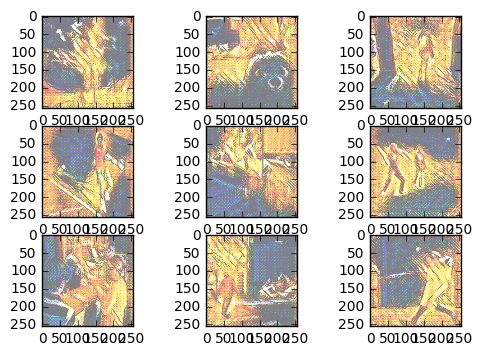

In [20]:
img_pred_np = sess.run(img_pred, feed_dict={img_train: test_batch_np})

f,axarr=plt.subplots(3,3)
for i in xrange(3):  
    for j in xrange(3):
        img = np.clip(img_pred_np[i*3+j],0,1)
        axarr[i][j].imshow(img)
plt.show()

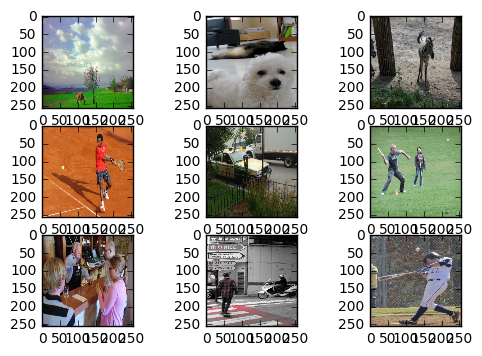

In [21]:
f,axarr=plt.subplots(3,3)
for i in xrange(3): 
    for j in xrange(3): 
        axarr[i][j].imshow(test_batch_np[i*3+j])
        plt.imsave(str(i*3+j)+)
plt.show()

In [22]:
saver=tf.train.Saver()
saver.save(sess, 'chkpt/cur.ckpt', global_step=None, latest_filename=None, write_meta_graph=False)

'chkpt/cur.ckpt'